In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%autosave 20

Autosaving every 20 seconds


In [2]:
from model.model import Net

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
from model.model import Net
from utils.optimizer import get_optimizer,run_lrfinder
from utils.model_fit import training,testing
from utils.data_loader import MNISTDataLoader
from torch import nn
import json
import plotext as plt
import numpy as np
import random
import os
import sys
from rf_calc import receptive_field
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from itertools import islice
import datetime
import argparse
import torch.nn.functional as F

### Configuration is loaded with NO LRfinder . Default lr is 0.015 (Random)

In [5]:
# %load config.json
{
    "seed":5,
    "best_model":0.993,
    "training": {
        "batch_size": 128,
        "epochs": 15,
        "start_lr": [1e-1],
        "end_lr": [2],
        "loss_type": "nll",
        "use_scheduler":0 ,
        "runlr_finer":0,
        "scheduler_type": "reducelronplateau",
        "lr_iter": 4500
    }
}

{'seed': 5,
 'best_model': 0.993,
 'training': {'batch_size': 128,
  'epochs': 15,
  'start_lr': [0.1],
  'end_lr': [2],
  'loss_type': 'nll',
  'use_scheduler': 0,
  'runlr_finer': 0,
  'scheduler_type': 'reducelronplateau',
  'lr_iter': 4500}}

### Prininting the model file just to make sure the input and Output is Correct and The structure is running correct

In [6]:
%pycat model/model.py

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

# Set default tensor type to float64
# torch.torch.set_default_dtype(torch.float64)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout = 0.01

        self.conv_layers = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), stride=1, padding=0, dilation=1, bias=True),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Dropout(self.dropout)
            ),  # input_size=28, output_size=26, receptive_field=3
            nn.Sequential(
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=0, dilation=1, bias=True),
                nn.BatchNorm2d(64),
        

In [7]:
%pycat utils/data_loader

import warnings
warnings.filterwarnings('ignore')
import torch
from torch.utils.data import Dataset,ConcatDataset
from torchvision import datasets,transforms
import gc
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from PIL import Image

class ThinAffineTransform:
    def __call__(self, img):
        # Define affine transformation matrix
        angle = 0  # No rotation
        scale = 1.0  # Maintain original scale
        shear = (0, 30)  # Apply horizontal shear
        width_scale = 0.7  # Compress width (thinner appearance)

        # Apply affine transform
        width, height = img.size
        new_width = int(width * width_scale)
        img = img.resize((new_width, height), Image.BILINEAR)
        return img


class MNISTDataLoader:
    def __init__(self, batch_size=64, seed=43):
        self.cuda = torch.cuda.is_available()
        self.batch_size = batch_size
        torch.manual_seed(seed)
        
        # Calculate mea

In [8]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # If using torch.backends.cudnn, set the following for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def get_model(device):
    model = Net().to(device)
    # model = model.float()
    return model

In [9]:
def run_model(model,device,batch_size,epochs,optimizer,scheduler,use_scheduler,best_model,version="v1",notes=""):
    # Create unique run name with version and timestamp
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    run_name = f"experiment_{version}_{timestamp}"
    current_lr = optimizer.param_groups[0]['lr']
    train_losses = []
    train_accuracy = []
    test_losses =[]
    test_accuracy = []
    print(summary(model, (1,28, 28 )))
    _ = receptive_field(model,28)
    
    for EPOCHS in range(0,epochs):
        train_loss, train_acc = training(model,device,train_loader,optimizer,EPOCHS)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)

        test_loss,test_acc = testing(model,device,test_loader,EPOCHS)
        test_accuracy.append(test_acc)
        test_losses.append(test_loss)    
        if (scheduler_type == 'reducelronplateau') & (use_scheduler ==True):
            scheduler.step(test_loss)
            current_lr = optimizer.param_groups[0]['lr']
        elif (scheduler_type == 'steplr') & (use_scheduler ==True):
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
        else:
            current_lr = optimizer.param_groups[0]['lr']

        try:
            if len(test_accuracy) > 1:
                if (EPOCHS >= 3 and 
                    max(test_accuracy[:-1]) < test_accuracy[-1] and 
                    max(test_accuracy) >= best_model):
                    
                    checkpoint = {
                        'epoch': EPOCHS + 1,
                        'valid_loss_min': test_losses[-1],
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    
                    file_name = f"./model_folder/modelbest_{test_accuracy[-1]:.4f}_epoch_{EPOCHS}.pt"
                    torch.save(checkpoint, file_name)
                    print(f"Target Achieved: {max(test_accuracy) * 100:.2f}% Test Accuracy!!")
                else:
                    print("Conditions not met for saving the model.")
            else:
                print("Insufficient test accuracy data.")
        except Exception as e:
            print(f"Model saving failed: {e}")

        print(f"LR: {current_lr}\n")
    return model,train_losses, train_accuracy,test_losses,test_accuracy

In [10]:
def load_config():
    with open('config.json', 'r') as f:
        return json.load(f)

In [11]:
def get_loss_function(loss_type):
    if loss_type is None:
        return nn.NLLLoss()   
    loss_types = {
        'cross_entropy': nn.CrossEntropyLoss(),
        'mse': nn.MSELoss(),
        'nll': nn.NLLLoss()
    }
    return loss_types.get(loss_type.lower(), nn.CrossEntropyLoss())

In [12]:
config = load_config()

# Set seed from config
set_seed(config['seed'])

In [13]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
# Get loss function and scheduler settings from config
loss_fn = get_loss_function(config['training'].get('loss_type'))
use_scheduler = config['training'].get('use_scheduler', False)
scheduler_type = config['training'].get('scheduler_type', 'steplr')
runlr_finer = config['training'].get('runlr_finer', False)
use_scheduler = bool(use_scheduler)
runlr_finer = bool(runlr_finer)

In [14]:
best_model = config['best_model']
version = 'v1'
notes = config['training'].get('notes', '')

In [15]:
# Set seed from config
_ = torch.manual_seed(config['seed'])
if torch.cuda.is_available():
    _ = torch.cuda.manual_seed(config['seed'])

In [16]:
# Get batch size based on device
batch_size = config['training']['batch_size']
epochs = config['training']['epochs']

In [17]:
model = get_model(device)
data_loader = MNISTDataLoader(batch_size=batch_size)
train_loader, test_loader = data_loader.get_data_loaders()

In [18]:
summary(model,(1,28,28))
from rf_calc import receptive_field
_= receptive_field(model,28)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
              ReLU-3           [-1, 32, 26, 26]               0
           Dropout-4           [-1, 32, 26, 26]               0
            Conv2d-5           [-1, 64, 24, 24]          18,496
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
           Dropout-8           [-1, 64, 24, 24]               0
            Conv2d-9          [-1, 128, 22, 22]          73,856
      BatchNorm2d-10          [-1, 128, 22, 22]             256
             ReLU-11          [-1, 128, 22, 22]               0
          Dropout-12          [-1, 128, 22, 22]               0
        MaxPool2d-13          [-1, 128, 11, 11]               0
           Conv2d-14           [-1, 16,

In [19]:
if runlr_finer:
    lrs,_ = run_lrfinder(
        model, 
        device, 
        train_loader, 
        test_loader, 
        start_lr=config['training']['start_lr'],
        end_lr=config['training']['end_lr'],
            lr_iter=config['training'].get('lr_iter', 1000)
        )
    print(lrs)
else:
    lrs = [0.015]

In [20]:
optimizer,scheduler = get_optimizer(model,scheduler = use_scheduler,\
                          scheduler_type = scheduler_type,lr = lrs[0])

In [21]:
model,train_losses, train_accuracy,test_losses,test_accuracy= run_model(model,device,batch_size,epochs,optimizer,scheduler,use_scheduler,best_model,version,notes)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
              ReLU-3           [-1, 32, 26, 26]               0
           Dropout-4           [-1, 32, 26, 26]               0
            Conv2d-5           [-1, 64, 24, 24]          18,496
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
           Dropout-8           [-1, 64, 24, 24]               0
            Conv2d-9          [-1, 128, 22, 22]          73,856
      BatchNorm2d-10          [-1, 128, 22, 22]             256
             ReLU-11          [-1, 128, 22, 22]               0
          Dropout-12          [-1, 128, 22, 22]               0
        MaxPool2d-13          [-1, 128, 11, 11]               0
           Conv2d-14           [-1, 16,

Train ==> Epochs: 0 Batch:  468 loss: 0.08108838647603989 Accuracy: 95.24% : 100%|██████████████████████████| 469/469 [00:05<00:00, 89.38it/s]
Test ==> Epochs: 0 Batch:  78 loss: 0.04080878247022629 Accuracy: 98.73% : 100%|█████████████████████████████| 79/79 [00:00<00:00, 176.48it/s]


Insufficient test accuracy data.
LR: 0.015



Train ==> Epochs: 1 Batch:  468 loss: 0.12077921628952026 Accuracy: 98.21% : 100%|██████████████████████████| 469/469 [00:05<00:00, 89.85it/s]
Test ==> Epochs: 1 Batch:  78 loss: 0.022012031580507754 Accuracy: 99.34% : 100%|████████████████████████████| 79/79 [00:00<00:00, 186.04it/s]


Conditions not met for saving the model.
LR: 0.015



Train ==> Epochs: 2 Batch:  468 loss: 0.028777437284588814 Accuracy: 98.59% : 100%|█████████████████████████| 469/469 [00:05<00:00, 89.40it/s]
Test ==> Epochs: 2 Batch:  78 loss: 0.018520529718731995 Accuracy: 99.38% : 100%|████████████████████████████| 79/79 [00:00<00:00, 187.37it/s]


Conditions not met for saving the model.
LR: 0.015



Train ==> Epochs: 3 Batch:  468 loss: 0.006717060226947069 Accuracy: 98.80% : 100%|█████████████████████████| 469/469 [00:05<00:00, 90.02it/s]
Test ==> Epochs: 3 Batch:  78 loss: 0.015551951071294024 Accuracy: 99.53% : 100%|████████████████████████████| 79/79 [00:00<00:00, 188.30it/s]


Target Achieved: 99.53% Test Accuracy!!
LR: 0.015



Train ==> Epochs: 4 Batch:  468 loss: 0.005436773877590895 Accuracy: 98.92% : 100%|█████████████████████████| 469/469 [00:05<00:00, 88.86it/s]
Test ==> Epochs: 4 Batch:  78 loss: 0.0183569044054253 Accuracy: 99.44% : 100%|██████████████████████████████| 79/79 [00:00<00:00, 180.32it/s]


Conditions not met for saving the model.
LR: 0.015



Train ==> Epochs: 5 Batch:  468 loss: 0.028601564466953278 Accuracy: 99.01% : 100%|█████████████████████████| 469/469 [00:05<00:00, 88.96it/s]
Test ==> Epochs: 5 Batch:  78 loss: 0.020698463481292128 Accuracy: 99.42% : 100%|████████████████████████████| 79/79 [00:00<00:00, 185.39it/s]


Conditions not met for saving the model.
LR: 0.015



Train ==> Epochs: 6 Batch:  468 loss: 0.02596227265894413 Accuracy: 99.11% : 100%|██████████████████████████| 469/469 [00:05<00:00, 89.23it/s]
Test ==> Epochs: 6 Batch:  78 loss: 0.01871329963756725 Accuracy: 99.39% : 100%|█████████████████████████████| 79/79 [00:00<00:00, 181.36it/s]


Conditions not met for saving the model.
LR: 0.015



Train ==> Epochs: 7 Batch:  468 loss: 0.028791645541787148 Accuracy: 99.17% : 100%|█████████████████████████| 469/469 [00:05<00:00, 88.87it/s]
Test ==> Epochs: 7 Batch:  78 loss: 0.01778180361086561 Accuracy: 99.48% : 100%|█████████████████████████████| 79/79 [00:00<00:00, 184.64it/s]


Conditions not met for saving the model.
LR: 0.015



Train ==> Epochs: 8 Batch:  468 loss: 0.004236356820911169 Accuracy: 99.20% : 100%|█████████████████████████| 469/469 [00:05<00:00, 89.41it/s]
Test ==> Epochs: 8 Batch:  78 loss: 0.0157159316958976 Accuracy: 99.53% : 100%|██████████████████████████████| 79/79 [00:00<00:00, 189.31it/s]


Conditions not met for saving the model.
LR: 0.015



Train ==> Epochs: 9 Batch:  468 loss: 0.005052738357335329 Accuracy: 99.25% : 100%|█████████████████████████| 469/469 [00:05<00:00, 88.77it/s]
Test ==> Epochs: 9 Batch:  78 loss: 0.01706214993575122 Accuracy: 99.47% : 100%|█████████████████████████████| 79/79 [00:00<00:00, 177.17it/s]


Conditions not met for saving the model.
LR: 0.015



Train ==> Epochs: 10 Batch:  468 loss: 0.0024896266404539347 Accuracy: 99.26% : 100%|███████████████████████| 469/469 [00:05<00:00, 88.66it/s]
Test ==> Epochs: 10 Batch:  78 loss: 0.016826544537208974 Accuracy: 99.43% : 100%|███████████████████████████| 79/79 [00:00<00:00, 179.52it/s]


Conditions not met for saving the model.
LR: 0.015



Train ==> Epochs: 11 Batch:  468 loss: 0.0024783045519143343 Accuracy: 99.33% : 100%|███████████████████████| 469/469 [00:05<00:00, 88.69it/s]
Test ==> Epochs: 11 Batch:  78 loss: 0.018697650517895816 Accuracy: 99.41% : 100%|███████████████████████████| 79/79 [00:00<00:00, 180.45it/s]


Conditions not met for saving the model.
LR: 0.015



Train ==> Epochs: 12 Batch:  468 loss: 0.06526672095060349 Accuracy: 99.29% : 100%|█████████████████████████| 469/469 [00:05<00:00, 87.91it/s]
Test ==> Epochs: 12 Batch:  78 loss: 0.011847031831624917 Accuracy: 99.61% : 100%|███████████████████████████| 79/79 [00:00<00:00, 183.82it/s]


Target Achieved: 99.61% Test Accuracy!!
LR: 0.015



Train ==> Epochs: 13 Batch:  468 loss: 0.01920461095869541 Accuracy: 99.37% : 100%|█████████████████████████| 469/469 [00:05<00:00, 89.02it/s]
Test ==> Epochs: 13 Batch:  78 loss: 0.01247209302354604 Accuracy: 99.64% : 100%|████████████████████████████| 79/79 [00:00<00:00, 185.24it/s]


Target Achieved: 99.64% Test Accuracy!!
LR: 0.015



Train ==> Epochs: 14 Batch:  468 loss: 0.045506175607442856 Accuracy: 99.42% : 100%|████████████████████████| 469/469 [00:05<00:00, 88.31it/s]
Test ==> Epochs: 14 Batch:  78 loss: 0.014981602120958268 Accuracy: 99.52% : 100%|███████████████████████████| 79/79 [00:00<00:00, 180.21it/s]


Conditions not met for saving the model.
LR: 0.015



In [22]:
print("Max Train Accuracy: ",max(train_accuracy))
print("Max Test Accuracy: ",max(test_accuracy))

Max Train Accuracy:  0.9942
Max Test Accuracy:  0.9964


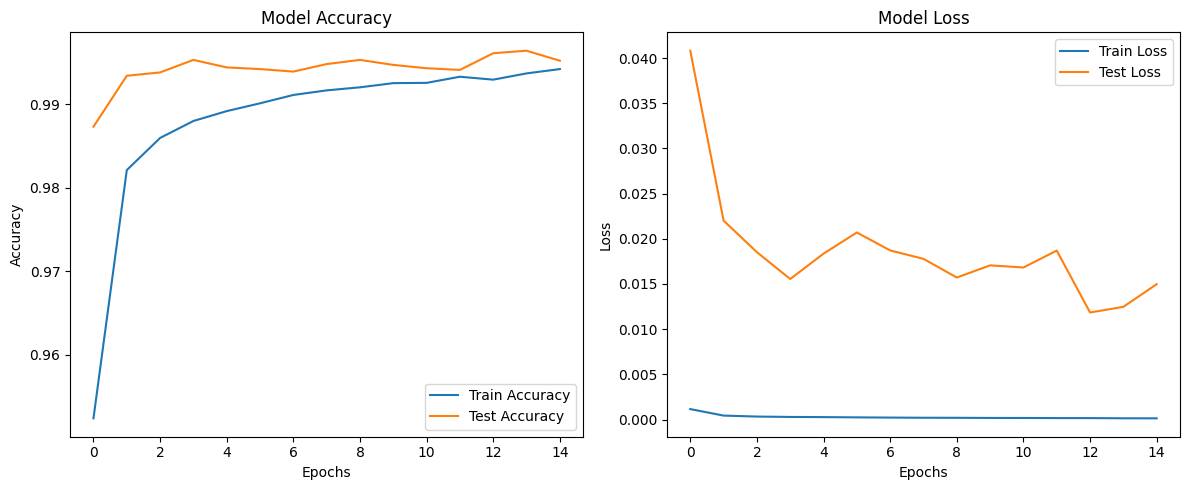

In [23]:
import matplotlib.pyplot as plt
# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize as needed

# Plot accuracy on the first subplot
_= axes[0].plot(train_accuracy, label="Train Accuracy")
_= axes[0].plot(test_accuracy, label="Test Accuracy")
_= axes[0].set_title("Model Accuracy")
_= axes[0].set_xlabel("Epochs")
_= axes[0].set_ylabel("Accuracy")
_= axes[0].legend()

# Plot loss on the second subplot
_= axes[1].plot(train_losses, label="Train Loss")
_= axes[1].plot(test_losses, label="Test Loss")
_= axes[1].set_title("Model Loss")
_= axes[1].set_xlabel("Epochs")
_= axes[1].set_ylabel("Loss")
_= axes[1].legend()

# Adjust layout and display the plots
_= plt.tight_layout()
_= plt.show()